In [1]:
import matplotlib
matplotlib.use('nbagg')
import yaggie
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Linking Positions into Trajectories

## Introduction

This notebook talks about how to use `yaggie.track` to link tracking results into trajectories

After tracking, typically we get a list, which contains positiosn of particles at different frames.

It looks like this

`[arr(number_2, dimension), ... , arr(number_i, dimension), ...]`

The link engine would link the positions into *trajectories*, a single trajectory looks like this

`{'time': [frame_1, frame_2, ...], 'position': [xyz_1, xyz_2, ...]}`

## Generate Random Data

Here we generated some randomly moving particles. The data to be tracked is `real_positions`, whose shape looks like `(time, number, dimension)`.

Notice different frames have different number of particles. This is common in practical tracking, because of tracking errors.

The movement (speed) of particles were generated from a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution): 

1. The mean is 0
2. The standard deviation ($\sigma$) of the distribution is set up by variable `speed`

In [2]:
np.random.seed(2)

particle_number = 8
frames = 200
speed = 2

tracked_numbers = np.random.randint(5, particle_number + 1, frames)
time_points = np.random.permutation(frames) 

full_positions = [np.random.uniform(-80, 80, (8, 3))] 
real_positions = [full_positions[-1].copy()]  # some particles missing

for f in range(frames - 1): 
    prev = full_positions[-1]
    current = prev + np.random.normal(0, speed, prev.shape)
    full_positions.append(current)
    real_positions.append(np.random.permutation(current)[:tracked_numbers[f]])

Let's see how the movement looks like, notices the tracking error

<IPython.core.display.Javascript object>


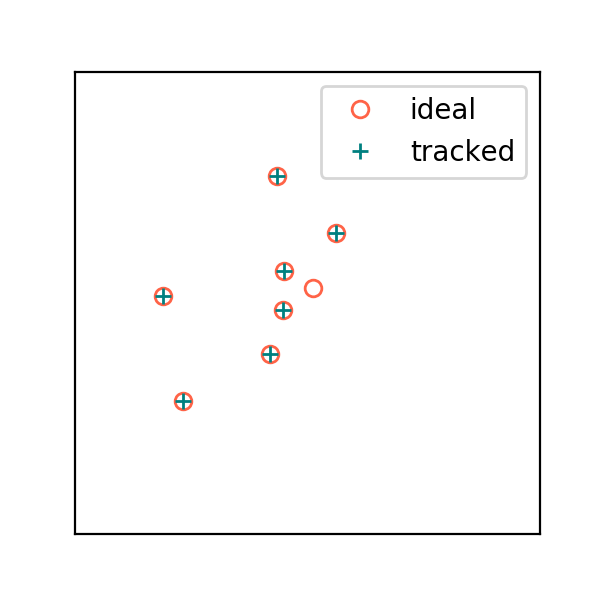

In [3]:
fig, ax = plt.subplots()
s1, = ax.plot([], [], 'bo', color='tomato', markerfacecolor='w', label='ideal')
s2, = ax.plot([], [], 'b+', color='teal', markerfacecolor='w', label='tracked')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.set_xticks([])
ax.set_yticks([])
fig.set_size_inches(3, 3)
plt.legend(loc='upper right')

def run(frame):
    # update the data
    x1, y1, z1 = full_positions[frame].T
    x2, y2, z2 = real_positions[frame].T
    s1.set_data(x1, y1)
    s2.set_data(x2, y2)
    return s1, s2

ani = animation.FuncAnimation(fig, run, frames=frames, repeat=False, interval=5)

plt.show()
plt.close()

## Link The positions (How to use the linker)

We use `yaggie.track.TrackpyEngine` to link the positions. The parameters to change are:

- `max_movement`: if two points' distance was larger than this value, they are not allowed to be linked
- `memory`: points were allowed to vanish for several frames

A proper choice of `max_movement` and `memory` leads to a good linking.

**Try to change the two values so that you get 8 trajectories finally**

In [4]:
te = yaggie.track.TrackpyEngine(max_movement=20, memory=8)
trajs = te.run(real_positions, time_points)
print("%s trajectories found!" % len(trajs))

Frame 199: 7 trajectories present.
8 trajectories found!


## What's the result (How to get useful result)

the `run` method returns a **list** that contains different trajectories. Each trajectory is a **dict** that has 

1. the positions at different frames (`trajectory['position']`)
2. the frame numbr at different frames (`trajectory['time']`)

The following use the positions and times to calculate the velocities (speeds) at different frames. Notice the close match between the measured velocity and their theoritical distribution!

<IPython.core.display.Javascript object>


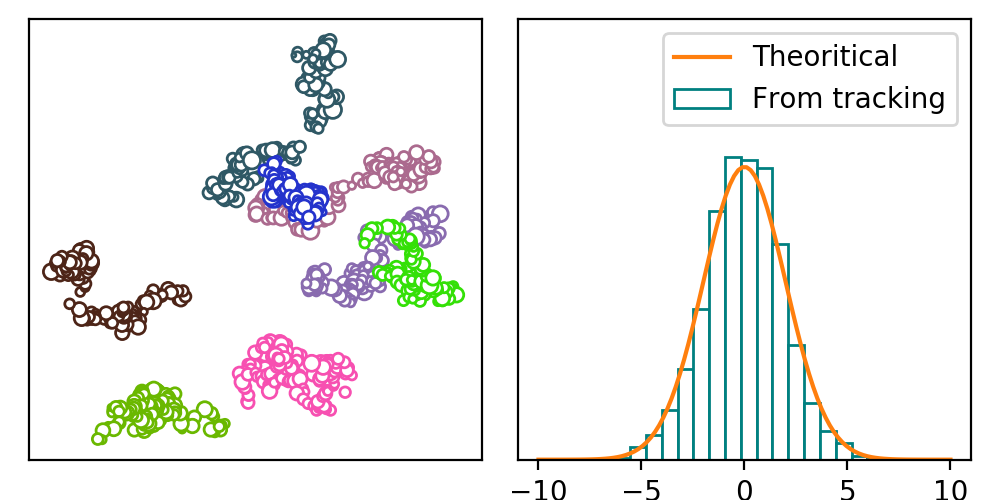

In [5]:
np.random.seed(1)
fig, ax = plt.subplots(1, 2)
velocities = []
for trajectory in trajs:
    positions = trajectory['position']
    time_points = trajectory['time']
    velocity = np.diff(positions, axis=0) / np.diff([time_points]).T
    
    norm_v = np.linalg.norm(velocity, axis=1)
    ax[0].scatter(*np.array(positions).T[:2], s=norm_v * 5,
                  edgecolor=np.random.random(3), facecolor='w')
    velocities.append(velocity.ravel())
    
ax[1].hist(np.hstack(velocities), bins=20, edgecolor='teal', facecolor='w', density=True, label='From tracking')
x = np.linspace(-10, 10, 100)
ax[1].plot(x, 1/(2 * np.pi * speed**2)**0.5 * np.exp(-x**2 / (2 * speed**2)), label = 'Theoritical')

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[1].set_ylim(0, 0.3)
plt.legend()
plt.tight_layout()
fig.set_size_inches(5, 2.5)
plt.show()

## Visualise the tracking result

There is a useful funciton in `yaggie` to visualise trajectories in 3D:

<IPython.core.display.Javascript object>


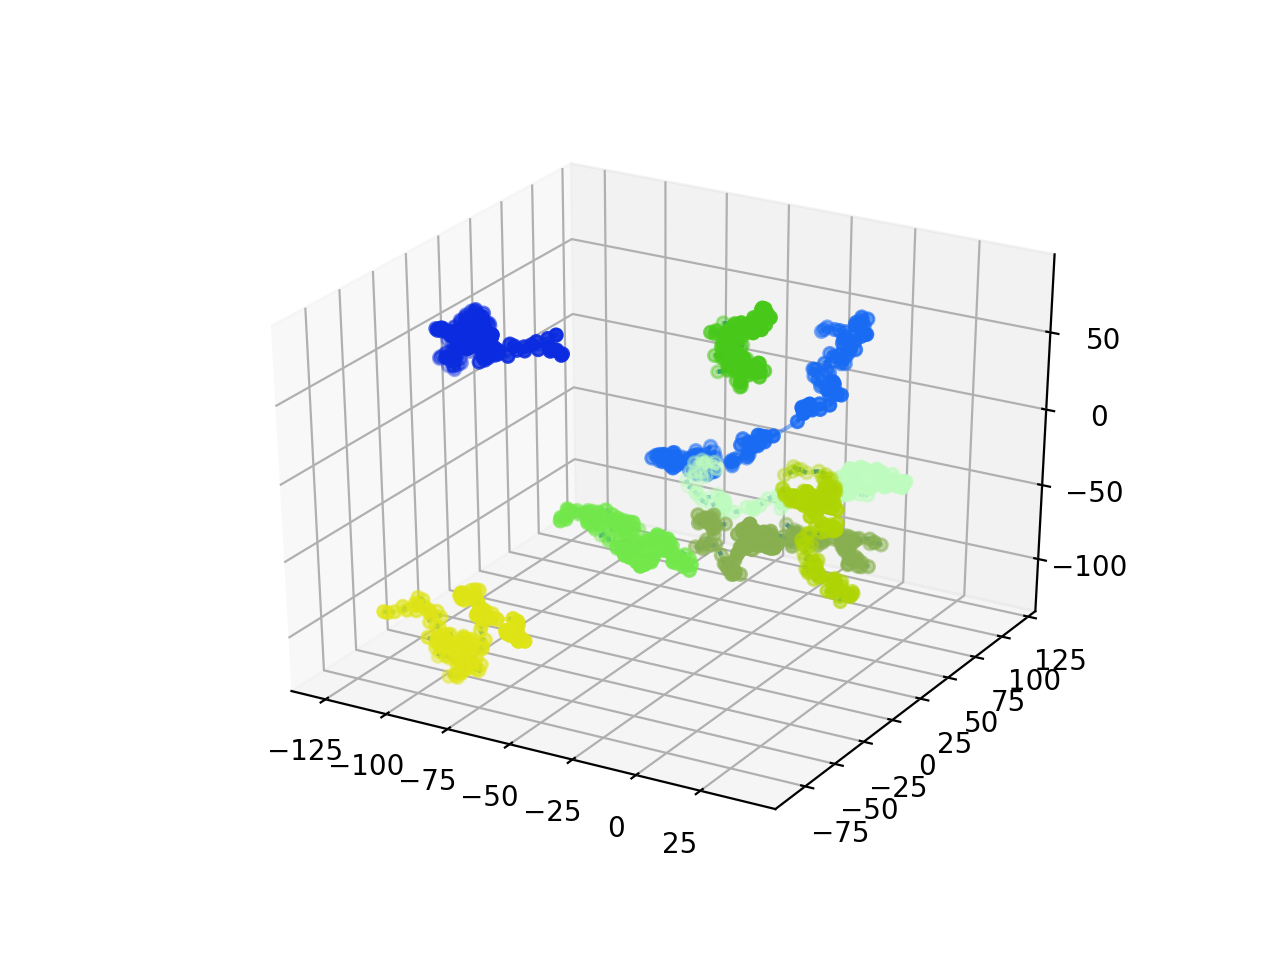

In [6]:
yaggie.utility.plot_trajectories(trajs, projection=False)
plt.close()

# Linking with Labels 

Sometimes, there are **labels** that comes with positions. For instance, we may have 2 particles in 3 frames. And the positions looks like this:

```
 frame |     position
---------------------------
   1   | [(x, y), (x', y')]
   2   | [(x, y), (x', y')]
   3   | [(x, y), (x', y')]
```

Suppose we not only know the positions, but also the *size* of the particles, so that we can *label* particles with either `big` or `small`, and our data looks like this:

```
 frame |     position       |       label
-----------------------------------------------
   1   | [(x, y), (x', y')] |  ['big', 'small']
   2   | [(x, y), (x', y')] |  ['small', 'big']
   3   | [(x, y), (x', y')] |  ['big', 'small']
```

after linking, we want something like this

```
Trajectory No. |  positions                      | labels 
------------------------------------------------------------------------------
     1         |  [(x, y), (x', y'), (x, y)]     |  ['big', 'big', 'big']
     2         |  [(x', y'), (x, y), (x', y')]   |  ['small', 'small', 'small']

```

This is possible now! Just pass the labels at different frames to the `run` method of the tracking engine returns the desired labels


## Generate Data with Labels


Each particle is now labeled with its size. Their sizes will not change while they were moving.

In [7]:
particle_number, frames, speed = 3, 10, 2

np.random.seed(6)
time_points = np.random.permutation(frames) 
tracked_numbers = np.random.randint(2, particle_number + 1, frames)  # sometims only 2 particles were tracked
true_label = ['small', 'medium', 'large']
true_labels = [true_label.copy() for _ in range(frames)]
real_labels = [true_label.copy()]

full_positions = [np.random.uniform(-80, 80, (particle_number, 3))] 
real_positions = [full_positions[-1].copy()]  # some particles missing

for f in range(frames - 1): 
    prev = full_positions[-1]
    current = prev + np.random.normal(0, speed, prev.shape)
    random_order = np.random.permutation(particle_number)[:tracked_numbers[f]]
    full_positions.append(current)
    real_positions.append(current[random_order])
    real_labels.append(np.array(true_label, dtype=str)[random_order].tolist())

## Link the positions with labels

We use `yaggie.track.TrackpyEngine` to link the positions. Please pass **a collection of labels at different frames** to the `run` method of the engine.

The labels looks like this:

```
[labels_in_frame_1, labels_in_frame_2, ...]
```

And the number of labels must equal the number of positions in the same frame.

In [8]:
te = yaggie.track.TrackpyEngine(max_movement=20, memory=8)
trajs = te.run(real_positions, time_points, labels=real_labels)  # <--- Passing labels!
print("%s trajectories found!" % len(trajs))

Frame 9: 2 trajectories present.
3 trajectories found!


for the obtained trajectories, each one has a `'label'` key, showing the label of one particle in different frames

In [9]:
for trajectory in trajs:
    print(trajectory['label'])

['small', 'small', 'small', 'small', 'small', 'small', 'small', 'small', 'small', 'small']
['medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium', 'medium']
['large', 'large', 'large', 'large', 'large', 'large', 'large', 'large', 'large']
